In [72]:
import brightway2 as bw
import bw2calc as bc
import bw2io as bi
import numpy as np
import pandas as pd

import plotly.express as px


In [73]:
if 'ei38-teaching' not in bw.projects:
    bi.restore_project_directory("/srv/data/projects/ecoinvent38.tar.gz")
    
bw.projects.set_current('ei38-teaching')

In [74]:
bw.databases

Databases dictionary with 5 object(s):
	2022
	biosphere3
	ecoinvent_image_SSP2-Base_2040
	ei 3.8 cutoff
	energy_moeschberg

In [75]:
ei = bw.Database("ei 3.8 cutoff")

In [76]:
foreground_importer = bi.ExcelImporter("./data/inputs/lci_moeschberg.xlsx")
for act in foreground_importer.data:
    # print(act["name"])
    for exc in act["exchanges"]:
        if "classifications" in exc:
            exc.pop("classifications")
        if "properties" in exc:
            exc.pop("properties")   
foreground_importer.apply_strategies()
foreground_importer.match_database("biosphere3", fields=("name", "unit", "categories"))
foreground_importer.match_database("ei 3.8 cutoff", fields=("name", "unit", "location"))
foreground_importer.statistics()
foreground_importer.write_database()

Extracted 1 worksheets in 0.01 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 6.78 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
5 datasets
18 exchanges
0 unlinked exchanges
  
Title: Writing activities to SQLite3 da

In [77]:
bw.databases

Databases dictionary with 5 object(s):
	2022
	biosphere3
	ecoinvent_image_SSP2-Base_2040
	ei 3.8 cutoff
	energy_moeschberg

In [78]:
foreground=bw.Database('energy_moeschberg')

In [79]:
fu=[act for act in foreground if 'opera' in act['name']][0]
fu

'energy demand, operational, Hotel Moeschberg' (unit, CH, None)

In [80]:
[act for act in foreground if '' in act['name']]

['electricity supply, Hotel Moeschberg, 2021' (kilowatt hour, CH, None),
 'heat supply, Hotel Moeschberg, 2021' (megajoule, CH, None),
 'energy demand, operational, Hotel Moeschberg' (unit, CH, None),
 'electricity supply, Energie Grosshoechstetten AG, 2021, guarantees of origin' (kilowatt hour, CH, None),
 'electricity, subsidised, 2021' (kilowatt hour, CH, None)]

In [81]:
ipcc=('IPCC 2013', 'climate change', 'GWP 100a')

In [82]:
lca=bw.LCA({fu:1},ipcc)
lca.lci()
lca.lcia()
lca.score

9310.091231235312

In [83]:
import bw2analyzer as ba

In [54]:
ba.print_recursive_supply_chain(fu)

1: 'energy demand, operational, Hotel Moeschberg' (unit, CH, None)
  3.22e+04: 'electricity supply, Hotel Moeschberg, 2021' (kilowatt hour, CH, None)
    1.8e+04: 'electricity supply, Energie Grosshoechstetten AG, 2021, guarantees of
    1.42e+04: 'electricity production, photovoltaic, 3kWp slanted-roof installation,
  6.55e+05: 'heat supply, Hotel Moeschberg, 2021' (megajoule, CH, None)
    3.06e+03: 'operation, solar collector system, Cu flat plate collector, one-famil
    6.52e+05: 'heat production, wood pellet, at furnace 25kW, state-of-the-art 2014'


In [56]:
ba.print_recursive_calculation(fu,ipcc,cutoff=1e-5,max_level=3)

Fraction of score | Absolute score | Amount | Activity
0001 |  9310 |     1 | 'energy demand, operational, Hotel Moeschberg' (unit, CH, None)
  0.132 |  1225 | 3.218e+04 | 'electricity supply, Hotel Moeschberg, 2021' (kilowatt hour, CH, None)
    0.0163 | 151.5 | 1.8e+04 | 'electricity supply, Energie Grosshoechstetten AG, 2021, guarantees of
      0.00627 | 58.36 | 1.633e+04 | 'electricity production, hydro, run-of-river' (kilowatt hour, CH, None
      0.00381 | 35.43 |   468 | 'electricity production, photovoltaic, 3kWp slanted-roof installation,
      0.0062 | 57.73 |  1206 | 'electricity, subsidised, 2021' (kilowatt hour, CH, None)
    0.115 |  1073 | 1.418e+04 | 'electricity production, photovoltaic, 3kWp slanted-roof installation,
      0.115 |  1073 | 0.1642 | 'photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounte
  0.868 |  8085 | 6.555e+05 | 'heat supply, Hotel Moeschberg, 2021' (megajoule, CH, None)
    0.00283 | 26.33 |  3060 | 'operation, solar collector sys

In [58]:
def parent(df):
    parent=[]
    for i in df.index:    
        if df.at[i,'Niveau']==0:
            parent.append('')
        elif df.at[i,'Niveau']==1:
            y=i
            while df.at[y,'Niveau']!=0:
                y=y-1
            parent.append(df.at[y,'Activities'])
        elif df.at[i,'Niveau']==3:
            y=i
            while df.at[y,'Niveau']!=2:
                y=y-1
            parent.append(df.at[y,'Activities'])
        elif df.at[i,'Niveau']==2:
            y=i
            while df.at[y,'Niveau']!=1:
                y=y-1
            parent.append(df.at[y,'Activities'])
    df['Parent']=parent
    return df

def LCA_treemap(names, values, niveau, activity, lcia_method, lca_obj=None, total_score=None, amount=1, level=0, max_level=3, cutoff=1e-2):
    
    if lca_obj is None:
        lca_obj = bc.LCA({activity: amount}, lcia_method)
        lca_obj.lci()
        lca_obj.lcia()
        total_score = lca_obj.score
    elif total_score is None:
        raise ValueError
    else:
        lca_obj.redo_lcia({activity: amount})
        if abs(lca_obj.score) >= abs(total_score * cutoff):
            names.append(activity["name"])    
            values.append(lca_obj.score/total_score*100)
            niveau.append(level)
    if level < max_level:
        for exc in activity.technosphere(): 
            LCA_treemap(
                names=names,
                values=values,
                niveau=niveau,
                activity=exc.input, 
                lcia_method=lcia_method, 
                lca_obj=lca_obj, 
                total_score=total_score, 
                amount=amount * exc['amount'], 
                level=level + 1, 
                max_level=max_level, 
                cutoff=cutoff
            )      
   
    return  parent(pd.DataFrame({'Activities':names,'Niveau':niveau,'Values':values}))

def LCA_plot_treemap(df):
    composants=[]
    ss_composants=[]
    ss_ss_composants=[]
    values=[]
    for i in df.index:
        if df.at[i,"Niveau"]==3:
            values.append(df.at[i,'Values'])
            ss_ss_composants.append(df.at[i,'Activities'])
            ss_composants.append(df.at[i,'Parent'])
            y=i
            while df.at[y,'Activities']!=df.at[i,'Parent']:
                y=y-1
            composants.append(df.at[y,'Parent'])
    return pd.DataFrame({'Composants':composants,'Sous composants':ss_composants,'Sous sous composants':ss_ss_composants,'Values':values})

In [ ]:
if True:
    names,values,niveau=['Eng demand'], [100], [0]
    df_Treemap=LCA_treemap(names,values,niveau,fu,ipcc,amount=1, level=0, max_level=3,cutoff=.001)
    Treemap=LCA_plot_treemap(df_Treemap)
    fig = px.treemap(Treemap, path=[px.Constant('Eng demand'),'Composants', 'Sous composants', 'Sous sous composants'],values='Values',width=1000, height=600,
                  color='Values',
                  color_continuous_scale='reds')
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.update_traces(hovertemplate=None, hoverinfo='value')
    fig.show()
    fig.write_html("./data/outputs/LCA_Contribution_Treemap.htm")

In [84]:
import pandas as pd
def fraction_scoreLCA(name_activity, share_of_activity, activity, lcia_method, lca_obj=None, total_score=None, amount=1, level=0, max_level=3, cutoff=1e-2):
    
    if lca_obj is None:
        lca_obj = bc.LCA({activity: amount}, lcia_method)
        lca_obj.lci()
        lca_obj.lcia()
        total_score = lca_obj.score
    elif total_score is None:
        raise ValueError
    else:
        lca_obj.redo_lcia({activity: amount})
        if abs(lca_obj.score) >= abs(total_score * cutoff):
            name_activity.append(activity["name"])    
            share_of_activity.append(lca_obj.score/total_score*100)    
    
    if level < max_level:
        for exc in activity.technosphere(): 
            fraction_scoreLCA(
                name_activity=name_activity,
                share_of_activity=share_of_activity,
                activity=exc.input, 
                lcia_method=lcia_method, 
                lca_obj=lca_obj, 
                total_score=total_score, 
                amount=amount * exc['amount'], 
                level=level + 1, 
                max_level=max_level, 
                cutoff=cutoff
            )      
    return name_activity, share_of_activity


In [92]:
name_CC, share_CC =[], []
name_CC,share_CC=fraction_scoreLCA(name_CC, share_CC,fu,ipcc,amount=1, level=0, max_level=1,cutoff=.01)
#attention si \delta_level>1 c'est le bazar : les parts affichés dépendront des levels où se situent les process(batt cell pro > cathod prod > LiCoO prod)


In [117]:
res_CC=pd.DataFrame(columns=name_CC,data=np.array(share_CC)[np.newaxis]).sort_index(axis=1) #newaxis oermet de transformer un vecteur ligne en colonne
res_CC.index=str(ipcc)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 3 elements

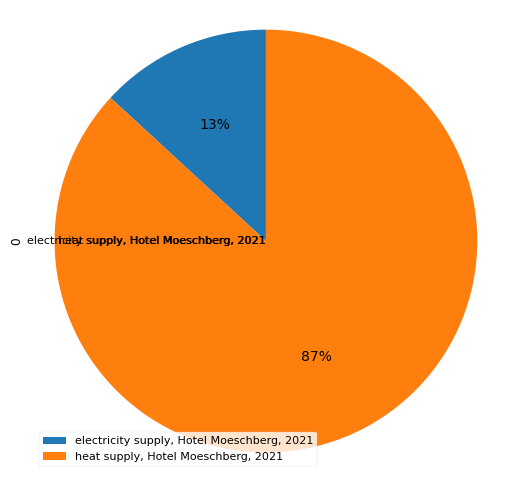

In [116]:
import matplotlib.pyplot as plt
figure,axes=plt.subplots(figsize=(6,6))
res_CC.T.plot(kind='pie',ax=axes,subplots=True,autopct='%1.0f%%',startangle = 90, labeldistance=0,legend=True)
plt.axis('equal')
figure.patch.set_facecolor('white')
